### House Prices: Advanced Regression Techniques

In [1]:
import numpy as np 
import pandas as pd
from datetime import datetime
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv('Downloads/train_1.csv')
test_df = pd.read_csv('Downloads/test_1.csv')

In [4]:
#Lets explore some details of the dataset : 
print ("Training Data: ",train_df.shape[0],"sales, and ",train_df.shape[1],"features")
print ("Testing Data: ",test_df.shape[0],"sales, and ",test_df.shape[1],"features")

Training Data:  1460 sales, and  81 features
Testing Data:  1459 sales, and  80 features


In [7]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


So the data contains NaN values and there are both type of variables (categorical and numerical)

Let's Start EDA (Exploratory Data Analysis)

So we can see that there are 1460 training data instances and almost the same number of instances for testing data (50%-50%).
Also there are a total of 81 features out of them some are numerical (quantitative) and some are categorical (qualitative).

In [14]:
numerical_dtype = [data for data in train_df.columns if train_df.dtypes[data] != 'object']
numerical_dtype.remove('SalePrice') # Since its the variable we are required to calculate
numerical_dtype.remove('Id') # It will not be a feature affecting price of houses
categorical_dtype = [data for data in train_df.columns if train_df.dtypes[data] == 'object']

In [25]:
print('Numerical Data Type: \n', numerical_dtype)
print('--'*60)
print('Categorical Data Type: \n',categorical_dtype)

Numerical Data Type: 
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
------------------------------------------------------------------------------------------------------------------------
Categorical Data Type: 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1

<AxesSubplot:>

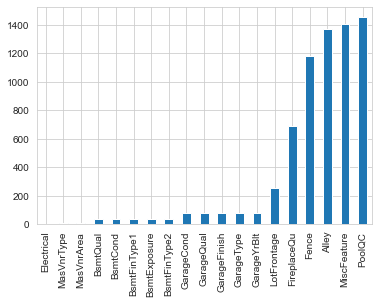

In [29]:
sns.set_style("whitegrid")
missed_data = train_df.isnull().sum()
missed_data = missed_data[missed_data > 0]
missed_data.sort_values(inplace=True)
missed_data.plot.bar()

Observation : There are about 5 data points which are missing majorly (more than 50%) and hence it will be better to not to consider them for our analysis. These 5 are : <br>
LotFrontage, FireplaceQu, Fence, Alley, MscFeature, PoolQC

To apply regression the decision will be based upon the current behaviour of our target varible. To check it: 

C:\Users\meghe\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Normal'}, xlabel='SalePrice'>

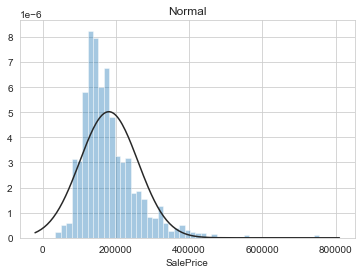

In [36]:
plt.figure(2); plt.title('Normal')
sns.distplot(train_df['SalePrice'], kde=False, fit=stats.norm)

Since its not normal so we need to transform the data before performing regression. 

In [39]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train_df[numerical_dtype])
normal = normal.apply(test_normality)

In [40]:
print(normal.any())

True


Now let's apply spearman correlation, but before that let us make some functions which will be used soon. <df>
Lets define a function named as encode, it's role is to clreate a datafra

In [47]:
def encode(df, ft):# df represents data frame and ft represents feature
    arrange = pd.DataFrame()  # it will create a dataframe named arrange
    arrange['val'] = df[ft].unique()  # it will create a column named val which contains unique values from the feature ft passed in our encode function
    arrange.index = arrange.val  # it will store val column in index of arrange dataframe
    arrange['spmean'] = df[[ft, 'SalePrice']].groupby(ft).mean()['SalePrice'] #it will create a column named spmean storing the mean value of salesproce and grouping by feature 
    arrange = arrange.sort_values('spmean') #it will sort the value and arrange it in order
    arrange['arrange'] = range(1, arrange.shape[0]+1) #it will create a column named arrange and store values ranging from 1 to length of arrange (like serial number)
    arrange = arrange['arrange'].to_dict() #it will convert a dataframe into a dictionary of series or list like data type depending on orient parameter 
    
    for cat, o in arrange.items():
        df.loc[df[ft] == cat, ft+'_E'] = o #access a group of rows and columns by label(s) in the given DataFrame.
    
categorical_encoded = []
for cd in categorical_dtype:  
    encode(train_df, cd)
    categorical_encoded.append(cd+'_E')
print(categorical_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


We can make another function named spearman for tabulating spearman corelation values 

In [48]:
def spearman(df, ft): #defining spearman function taking data frame and feature as inputs
    spr = pd.DataFrame() # creating a dataframe spr
    spr['feature'] = ft # creating a columne named feature storing the feature passed
    spr['spearman'] = [df[f].corr(df['SalePrice'], 'spearman') for f in ft] #storing spearman coorelation 
    spr = spr.sort_values('spearman') # sorting value in order based on spearman values
    plt.figure(figsize=(6, 0.25*len(ft))) 
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
ft = numerical_dtype + categorical_encoded # covering both type of features
#spearman(train, ft)

<AxesSubplot:>

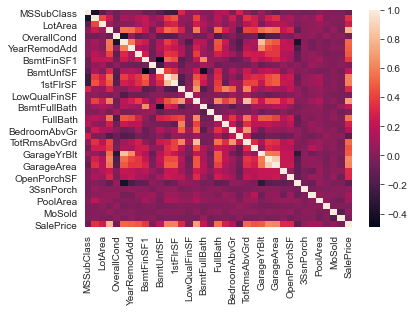

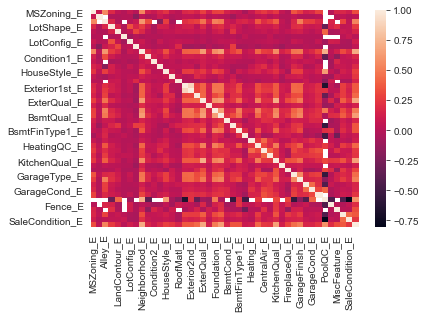

In [50]:
plt.figure(1)
corr = train_df[numerical_dtype+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train_df[categorical_encoded+['SalePrice']].corr()
sns.heatmap(corr)


Observation : We can see the correlation between the variables using heat map

Clustering using TSNE : 

0.7549852454396213


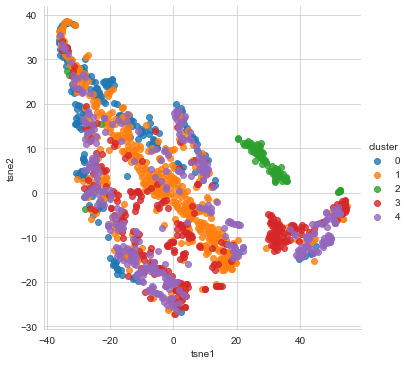

In [52]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train_df[features].fillna(0.).values
tsne = model.fit_transform(X)

s = StandardScaler().fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

Now Let's Proceed towards processing the data: 

In [53]:
train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

In [55]:
train_df = train_df[train_df.GrLivArea < 4500]
train_df.reset_index(drop=True, inplace=True)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
y = train_df['SalePrice'].reset_index(drop=True)

In [56]:
train_ft = train_df.drop(['SalePrice'], axis=1)
test_ft = test_df
ft = pd.concat([train_ft, test_ft]).reset_index(drop=True)

In [57]:
ft.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


In [60]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    ft[col] = ft[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    ft[col] = ft[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    ft[col] = ft[col].fillna('None')

ft['MSZoning'] = ft.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [62]:
obj = []
for i in ft.columns:
    if ft[i].dtype == obj:
        obj.append(i)
ft.update(ft[obj].fillna('None'))

ft['LotFrontage'] = ft.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

num_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nums = []
for i in ft.columns:
    if ft[i].dtype in num_dtypes:
        nums.append(i)
ft.update(ft[nums].fillna(0))

In [65]:
num_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num2 = []
for i in ft.columns:
    if ft[i].dtype in num_dtypes:
        num2.append(i)
skew_ft = ft[num2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_ft[skew_ft > 0.5]
skew_index = high_skew.index

for i in skew_index:
    ft[i] = boxcox1p(ft[i], boxcox_normmax(ft[i] + 1))

In [66]:
ft = ft.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

ft['YrBltAndRemod']=ft['YearBuilt']+ft['YearRemodAdd']
ft['TotalSF']=ft['TotalBsmtSF'] + ft['1stFlrSF'] + ft['2ndFlrSF']

ft['Total_sqr_footage'] = (ft['BsmtFinSF1'] + ft['BsmtFinSF2'] +
                                 ft['1stFlrSF'] + ft['2ndFlrSF'])

ft['Total_Bathrooms'] = (ft['FullBath'] + (0.5 * ft['HalfBath']) +
                               ft['BsmtFullBath'] + (0.5 * ft['BsmtHalfBath']))

ft['Total_porch_sf'] = (ft['OpenPorchSF'] + ft['3SsnPorch'] +
                              ft['EnclosedPorch'] + ft['ScreenPorch'] +
                              ft['WoodDeckSF'])

In [67]:
ft['haspool'] = ft['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
ft['has2ndfloor'] = ft['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
ft['hasgarage'] = ft['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
ft['hasbsmt'] = ft['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
ft['hasfireplace'] = ft['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [68]:
final_ft = pd.get_dummies(ft).reset_index(drop=True)
final_ft.shape

(2917, 342)

In [70]:
X = final_ft.iloc[:len(y), :]
X_sub = final_ft.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 342), (1458,), (1459, 342))

In [72]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [73]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [74]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

In [85]:
def blend_models_predict(X):
    return ((0.1 * gbr.predict(X)))

In [88]:
print('RMSLE score on train data:')
gbr_model_full_data = gbr.fit(X, y)
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
2.309827538550028
